# **Práctica 5 Construir modelo ARIMA**

**Carrera:** Licenciatura en Ciencia de Datos

**Grupo:**  6AV1

**Materia:** Análisis de Series de Tiempo

**Docente:** Daniel Jiménez Alcantar

**Integrantes:**  

* Aguilar Ramirez Carlos Francisco
* Arista Romero Juan Ismael
* Jiménez Flores Luis Arturo
* Vazquez Martin Marlene Gabriela

Fecha de última modificación: 13/04/2025

## **1. SETUP: Importar Bibliotecas y Montar Drive (si es necesario)**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import find_peaks
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") # Opcional: para ocultar advertencias comunes

#Importar si y solo si el conjunto de datos está alojado en su drive
#from google.colab import drive
#drive.mount('/content/drive')

print("--- Librerías importadas ---")

--- Librerías importadas ---


## **2. CARGA Y PREPARACIÓN INICIAL DE LOS DATOS**


Este conjunto de datos contiene datos históricos del precio de las acciones de Walmart Inc. (WMT) desde el 25 de agosto de 1972 hasta el 21 de febrero de 2025.

**Extracción**

In [ ]:
df = pd.read_csv("/content/WMT.csv")

* Carga del CSV, verificación de valores nulos, ordenación cronológica, conversión de fechas a datetime, etc.

In [ ]:
df.head()

,date,open,high,low,close,adj_close,volume
0,1972-08-25 00:00:00-04:00,0.021159,0.021566,0.021159,0.021484,0.011639,7526400
1,1972-08-28 00:00:00-04:00,0.021484,0.021647,0.021403,0.021403,0.011595,2918400
2,1972-08-29 00:00:00-04:00,0.021322,0.021322,0.021159,0.021159,0.011463,5836800
3,1972-08-30 00:00:00-04:00,0.021159,0.021159,0.020996,0.021159,0.011463,1228800
4,1972-08-31 00:00:00-04:00,0.020996,0.020996,0.020833,0.020833,0.011286,2611200


In [ ]:
df.tail()

,date,open,high,low,close,adj_close,volume
13228,2025-02-14 00:00:00-05:00,105.300003,105.300003,103.599998,104.040001,104.040001,14109500
13229,2025-02-18 00:00:00-05:00,103.720001,103.989998,102.510002,103.779999,103.779999,18247300
13230,2025-02-19 00:00:00-05:00,103.849998,104.199997,102.550003,104.000000,104.000000,18508000
13231,2025-02-20 00:00:00-05:00,98.779999,100.120003,96.680000,97.209999,97.209999,55450900
13232,2025-02-21 00:00:00-05:00,96.529999,96.849998,94.120003,94.779999,94.779999,34972500


In [ ]:
df.describe()

,open,high,low,close,adj_close,volume
count,13233.000000,13233.000000,13233.000000,13233.000000,13233.000000,1.323300e+04
mean,14.428567,14.558144,14.300811,14.432343,11.946184,2.244184e+07
std,16.498454,16.627365,16.374295,16.506102,15.865462,1.839004e+07
min,0.005208,0.005208,0.004801,0.005208,0.002839,0.000000e+00
25%,0.557292,0.562500,0.552083,0.557292,0.332387,1.190220e+07
50%,11.500000,11.593750,11.291667,11.468750,7.350797,1.875690e+07
75%,20.062500,20.256666,19.883333,20.043333,14.910351,2.801850e+07
max,105.300003,105.300003,103.599998,105.050003,105.050003,3.955008e+08


In [ ]:
# Convertir la columna date a tipo datetime y ordenar los registros cronológicamente para facilitar análisis de series temporales
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

In [ ]:
# Verificar si existen valores faltantes en el dataset
faltantes = df.isnull().sum()
faltantes

,0
date,0
open,0
high,0
low,0
close,0
adj_close,0
volume,0


In [ ]:
# Comprobar brevemente la distribución y presencia de valores extremos mediante percentiles extremos
percentiles = df['adj_close'].quantile([0.01, 0.05, 0.95, 0.99])
percentiles

,adj_close
0.01,0.005291
0.05,0.009169
0.95,46.126460
0.99,70.361108


**Transformación**

Esto corresponde a la preparación de la serie y detección de valores atípicos o problemas de calidad.

In [ ]:
# Convertir a datetime con UTC para asegurar que todo esté correcto
df['date'] = pd.to_datetime(df['date'], utc=True)

# Crear dataframe limpio con fecha y adj_close únicamente
walmart_clean_df = df[['date', 'adj_close']].copy()

# Eliminar la hora, dejando solo la fecha
walmart_clean_df['date'] = walmart_clean_df['date'].dt.date

# Verificar el resultado
print(walmart_clean_df.head())

         date  adj_close
0  1972-08-25   0.011639
1  1972-08-28   0.011595
2  1972-08-29   0.011463
3  1972-08-30   0.011463
4  1972-08-31   0.011286


Una vez cargados y limpiados los datos en el DataFrame con el nombre "walmart_clean_df" cuyo contenido son las columnas 'date' y 'adj_close' se tiene el conjunto listo para el análisis.

**Carga**

In [ ]:
# Mostrar información básica del DataFrame cargado
print("\n--- Información del DataFrame Original (df) ---")
print("Primeras 5 filas:")
print(walmart_clean_df.head())
print("\nÚltimas 5 filas:")
print(walmart_clean_df.tail())
print("\nEstadísticas descriptivas:")
print(walmart_clean_df.describe())


--- Información del DataFrame Original (df) ---
Primeras 5 filas:
         date  adj_close
0  1972-08-25   0.011639
1  1972-08-28   0.011595
2  1972-08-29   0.011463
3  1972-08-30   0.011463
4  1972-08-31   0.011286

Últimas 5 filas:
             date   adj_close
13228  2025-02-14  104.040001
13229  2025-02-18  103.779999
13230  2025-02-19  104.000000
13231  2025-02-20   97.209999
13232  2025-02-21   94.779999

Estadísticas descriptivas:
          adj_close
count  13233.000000
mean      11.946184
std       15.865462
min        0.002839
25%        0.332387
50%        7.350797
75%       14.910351
max      105.050003


## **3. SELECCIÓN DE VARIABLE Y PREPARACIÓN FINAL DE LA SERIE**

In [ ]:
print("\n--- Preparación de la Serie de Tiempo (adj_close) ---")
# Seleccionar columnas 'date' y 'adj_close'
# Usar .copy() para evitar SettingWithCopyWarning
walmart_ts_df = df[['date', 'adj_close']].copy()

# Establecer 'date' como índice
walmart_ts_df.set_index('date', inplace=True)

# Definir la serie objetivo
serie = walmart_ts_df['adj_close'].dropna() # Asegurarse de no tener NaNs en la serie final

print(f"\nSerie 'adj_close' preparada. Longitud: {len(serie)} puntos.")
print(f"Fechas desde {serie.index.min()} hasta {serie.index.max()}")
print("Últimas 5 observaciones de la serie:")
print(serie.tail())


--- Preparación de la Serie de Tiempo (adj_close) ---

Serie 'adj_close' preparada. Longitud: 13233 puntos.
Fechas desde 1972-08-25 04:00:00+00:00 hasta 2025-02-21 05:00:00+00:00
Últimas 5 observaciones de la serie:
date
2025-02-14 05:00:00+00:00    104.040001
2025-02-18 05:00:00+00:00    103.779999
2025-02-19 05:00:00+00:00    104.000000
2025-02-20 05:00:00+00:00     97.209999
2025-02-21 05:00:00+00:00     94.779999
Name: adj_close, dtype: float64


## **4. ANÁLISIS EXPLORATORIO DE DATOS (EDA)**


--- Iniciando Análisis Exploratorio de Datos (EDA) ---

4.1 Visualización de la Serie Temporal...


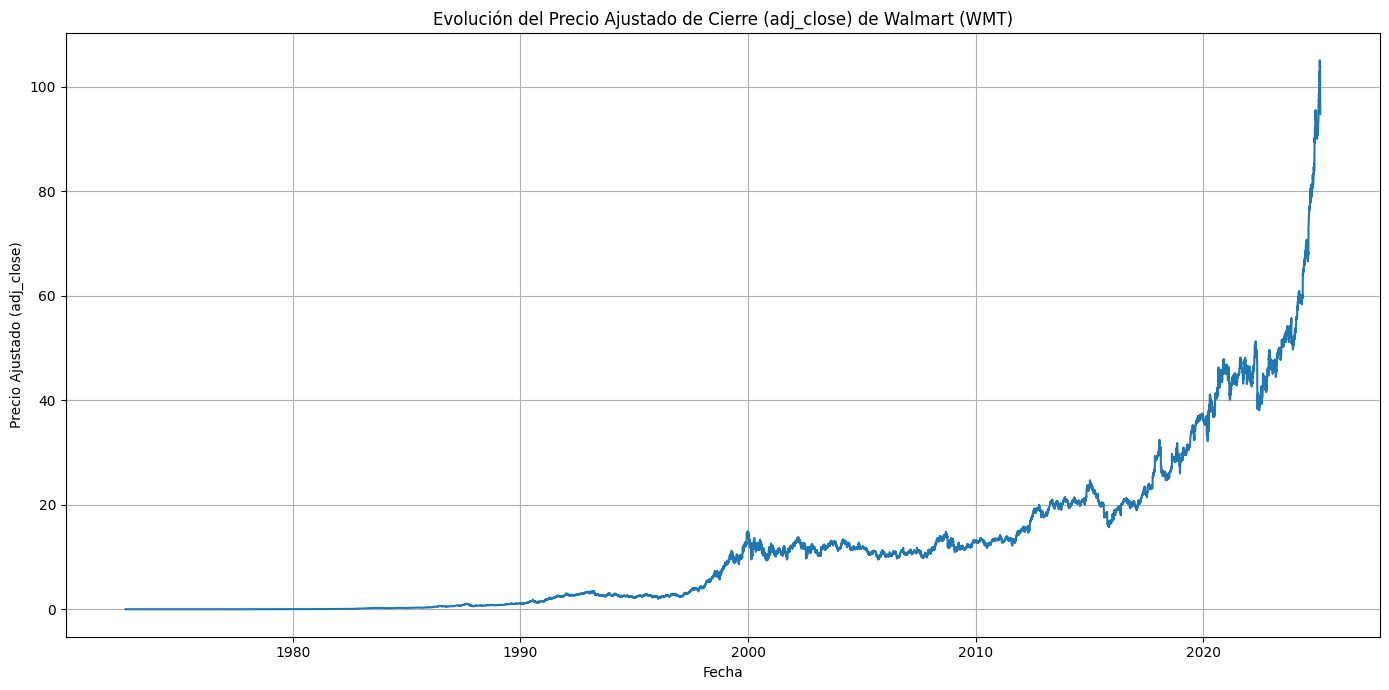

In [ ]:
print("\n--- Iniciando Análisis Exploratorio de Datos (EDA) ---")

# 4.1 Gráfico de la Serie Temporal
print("\n4.1 Visualización de la Serie Temporal...")
plt.figure(figsize=(14, 7))
plt.plot(serie.index, serie, linewidth=1.5)
plt.title('Evolución del Precio Ajustado de Cierre (adj_close) de Walmart (WMT)')
plt.xlabel('Fecha')
plt.ylabel('Precio Ajustado (adj_close)')
plt.grid(True)
plt.tight_layout()
plt.show()

### **4.2 Estadísticas Descriptivas de la Serie**

In [ ]:
print("\n4.2 Estadísticas Descriptivas de 'adj_close'...")
mean_value = serie.mean()
median_value = serie.median()
# La moda puede ser menos informativa para series continuas y puede haber múltiples
mode_value = serie.mode().iloc[0] if not serie.mode().empty else 'N/A'
std_dev = serie.std()
variance = serie.var()
percentiles = serie.quantile([0.01, 0.05, 0.95, 0.99])

stats_results = {
    "Promedio (Media)": mean_value,
    "Mediana": median_value,
    "Moda": mode_value,
    "Desviación Estándar": std_dev,
    "Varianza": variance
}
print("Estadísticas básicas:")
for key, value in stats_results.items():
    print(f"  {key}: {value:.4f}")
print("\nPercentiles extremos:")
print(percentiles)



4.2 Estadísticas Descriptivas de 'adj_close'...
Estadísticas básicas:
  Promedio (Media): 11.9462
  Mediana: 7.3508
  Moda: 0.0069
  Desviación Estándar: 15.8655
  Varianza: 251.7129

Percentiles extremos:
0.01     0.005291
0.05     0.009169
0.95    46.126460
0.99    70.361108
Name: adj_close, dtype: float64


### 4.**3 Granularidad, Máximos y Mínimos**

In [ ]:
print("\n4.3 Análisis de Granularidad, Máximos y Mínimos...")
# Granularidad (requiere el índice como datetime, lo cual ya está)
if isinstance(serie.index, pd.DatetimeIndex):
    date_diff_counts = serie.index.to_series().diff().dt.days.value_counts().head()
    print("Granularidad (diferencias más frecuentes en días):")
    print(date_diff_counts)
else:
    print("El índice no es DatetimeIndex, no se puede calcular diferencia de días fácilmente.")

# Máximos y Mínimos globales
max_price_val = serie.max()
max_price_date = serie.idxmax()
min_price_val = serie.min()
min_price_date = serie.idxmin()
print(f"\nMáximo absoluto: {max_price_val:.4f} el {max_price_date.strftime('%Y-%m-%d')}")
print(f"Mínimo absoluto: {min_price_val:.4f} el {min_price_date.strftime('%Y-%m-%d')}")



4.3 Análisis de Granularidad, Máximos y Mínimos...
Granularidad (diferencias más frecuentes en días):
date
1.0    10361
3.0     2369
4.0      319
2.0      180
5.0        2
Name: count, dtype: int64

Máximo absoluto: 105.0500 el 2025-02-13
Mínimo absoluto: 0.0028 el 1974-12-10


### **4.4 Análisis de Tendencia (Media Móvil)**


4.4 Visualización de Tendencia (Media Móvil Anual)...


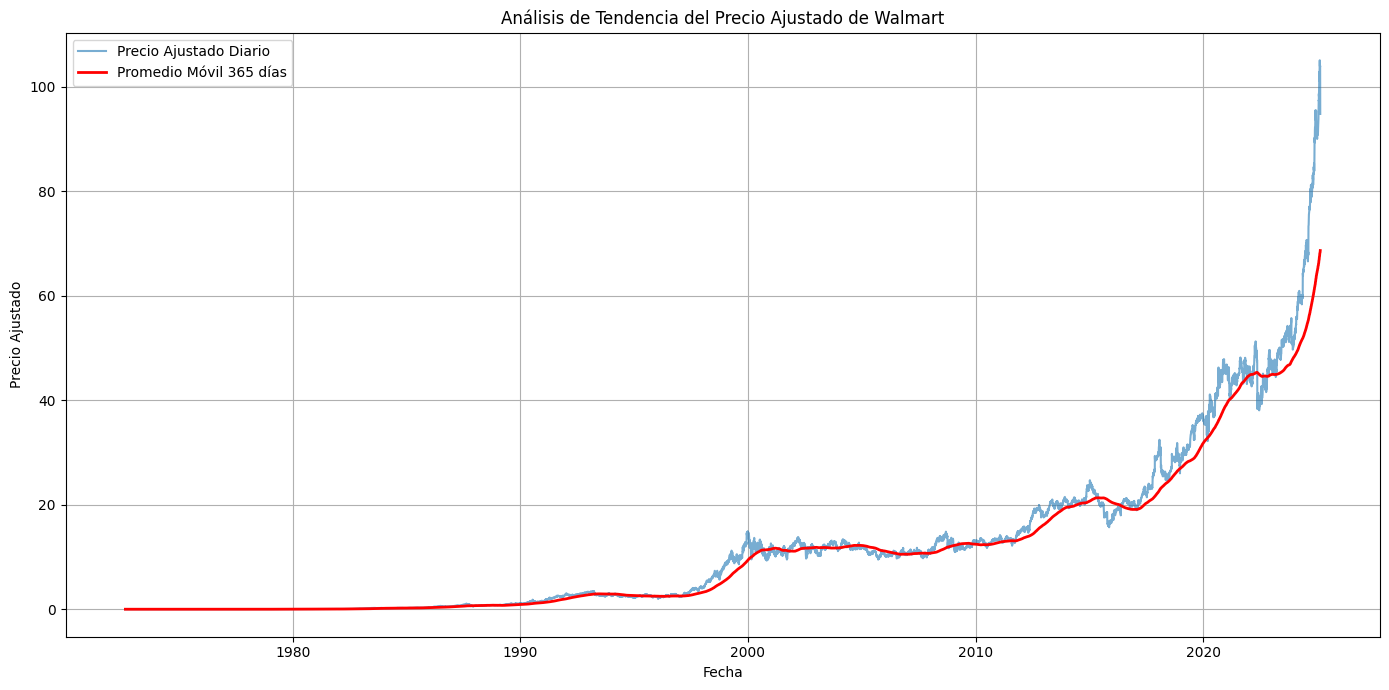

In [ ]:
print("\n4.4 Visualización de Tendencia (Media Móvil Anual)...")
rolling_window = 365 # Aproximadamente un año
serie_moving_avg = serie.rolling(window=rolling_window, min_periods=1).mean()

plt.figure(figsize=(14, 7))
plt.plot(serie.index, serie, alpha=0.6, label='Precio Ajustado Diario')
plt.plot(serie_moving_avg.index, serie_moving_avg, color='red', linewidth=2, label=f'Promedio Móvil {rolling_window} días')
plt.title('Análisis de Tendencia del Precio Ajustado de Walmart')
plt.xlabel('Fecha')
plt.ylabel('Precio Ajustado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **4.5 Descomposición Estacional (Exploratoria)**


4.5 Descomposición Estacional (Exploratoria)...
Realizando descomposición multiplicativa con periodo=252


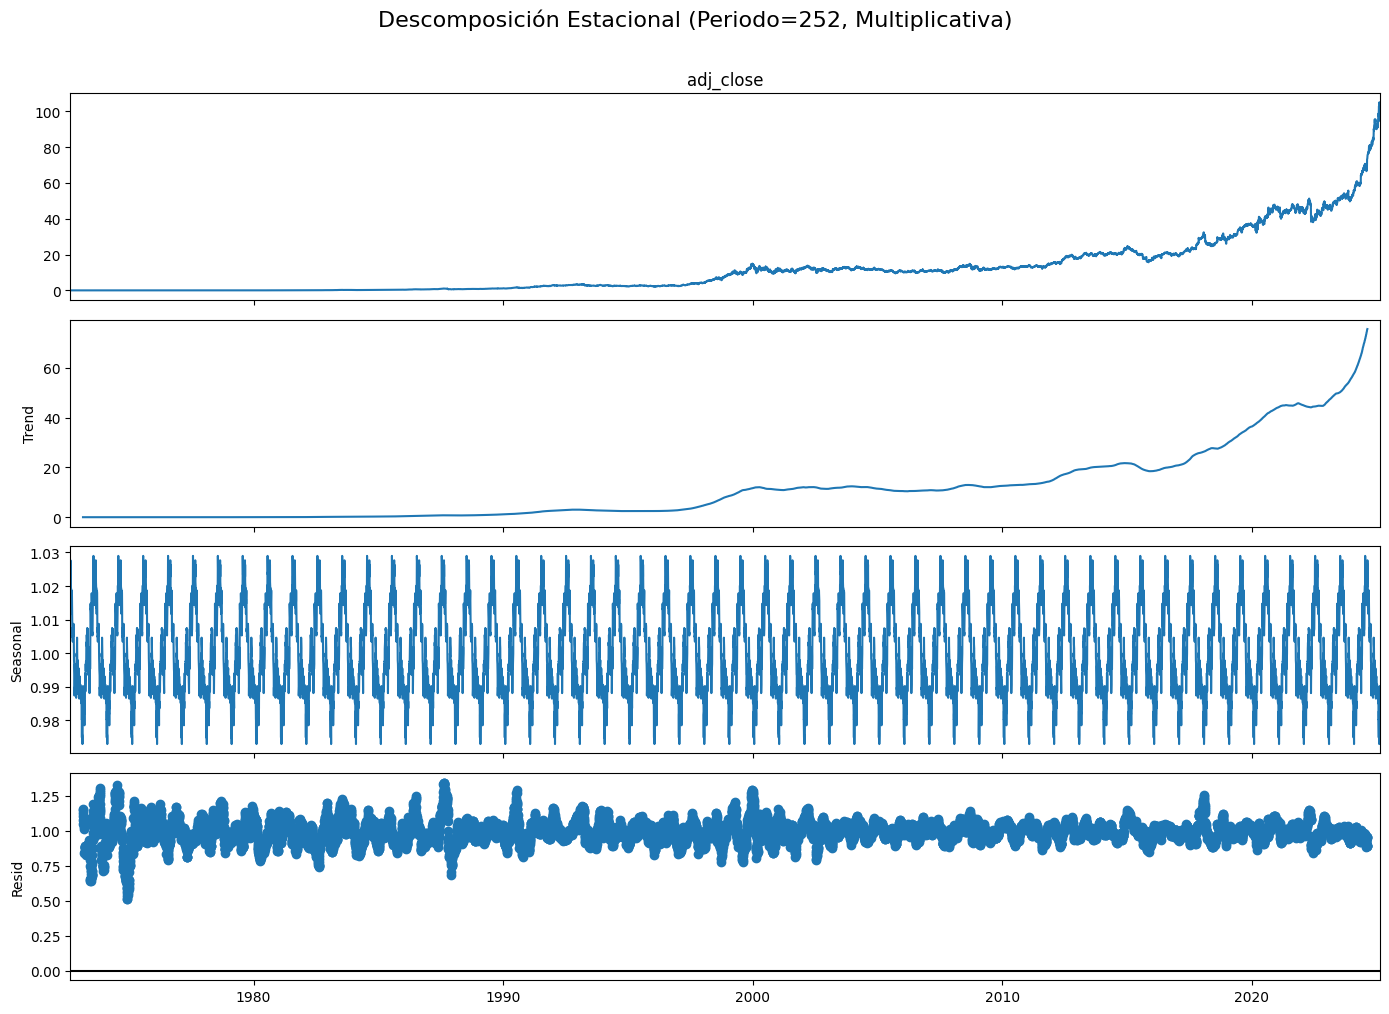

In [ ]:
print("\n4.5 Descomposición Estacional (Exploratoria)...")
# Elegir un período; 252 es común para días bursátiles anuales
# La descomposición puede ser sensible al período elegido y al modelo (add/mult)
periodo_descomposicion = 252
try:
    # Usar modelo multiplicativo si los valores son > 0 y la amplitud parece crecer con el nivel
    # Usar modelo aditivo si la amplitud parece constante
    decomposition = seasonal_decompose(serie, model='multiplicative', period=periodo_descomposicion)
    print(f"Realizando descomposición multiplicativa con periodo={periodo_descomposicion}")

    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    plt.suptitle(f'Descomposición Estacional (Periodo={periodo_descomposicion}, Multiplicativa)', y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Error en descomposición multiplicativa (quizás por ceros o negativos): {e}")
    try:
        decomposition = seasonal_decompose(serie, model='additive', period=periodo_descomposicion)
        print(f"Intentando descomposición aditiva con periodo={periodo_descomposicion}")
        fig = decomposition.plot()
        fig.set_size_inches(14, 10)
        plt.suptitle(f'Descomposición Estacional (Periodo={periodo_descomposicion}, Aditiva)', y=1.01, fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e2:
        print(f"Error también en descomposición aditiva: {e2}")

### **4.6 Picos y Valles Locales (Exploratorio)**


4.6 Identificación de Picos y Valles Locales...


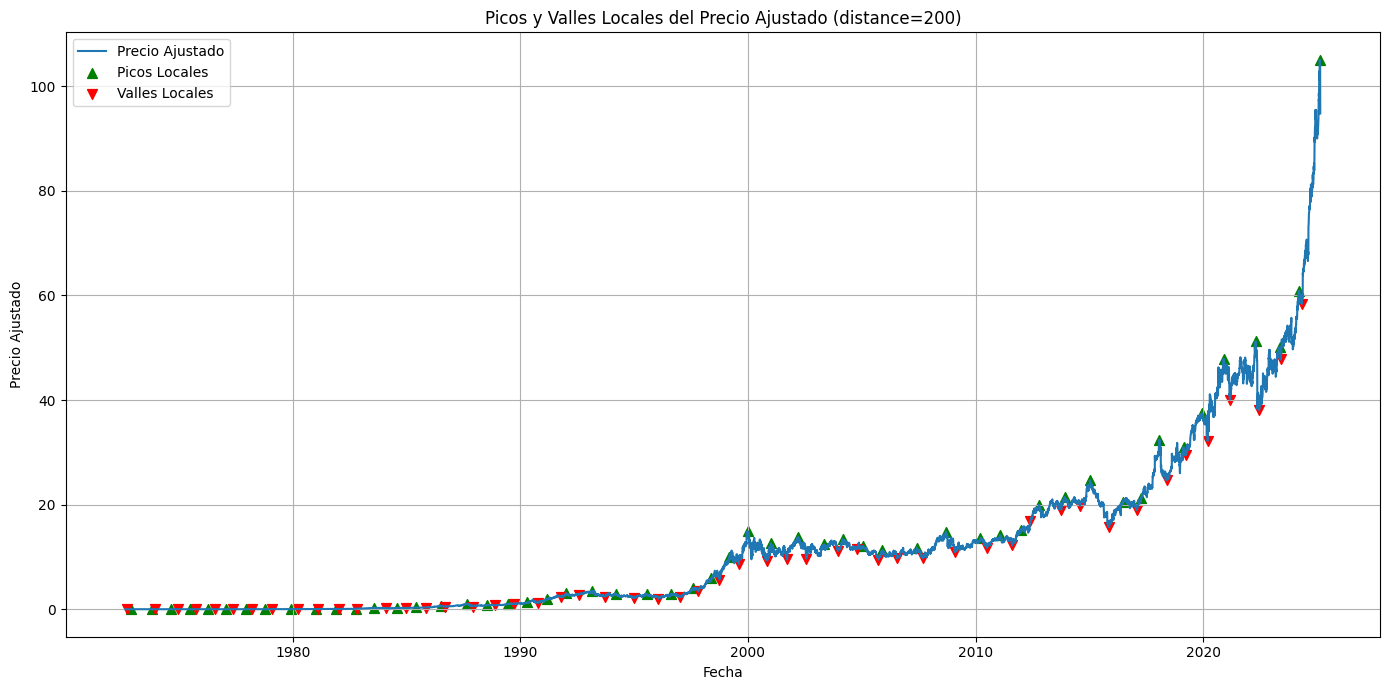

Número de picos locales detectados: 54
Número de valles locales detectados: 52


In [ ]:
print("\n4.6 Identificación de Picos y Valles Locales...")
# La 'distance' es importante, ajustarla según la escala de tiempo esperada entre picos/valles
distancia_picos = 200 # Número mínimo de puntos entre picos/valles

peaks_indices, _ = find_peaks(serie, distance=distancia_picos)
peaks = serie.iloc[peaks_indices]

valleys_indices, _ = find_peaks(-serie, distance=distancia_picos) # Invertir para encontrar mínimos
valleys = serie.iloc[valleys_indices]

plt.figure(figsize=(14, 7))
plt.plot(serie.index, serie, label='Precio Ajustado')
plt.scatter(peaks.index, peaks.values, color='green', label='Picos Locales', marker='^', s=50)
plt.scatter(valleys.index, valleys.values, color='red', label='Valles Locales', marker='v', s=50)
plt.title(f'Picos y Valles Locales del Precio Ajustado (distance={distancia_picos})')
plt.xlabel('Fecha')
plt.ylabel('Precio Ajustado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Número de picos locales detectados: {len(peaks)}")
print(f"Número de valles locales detectados: {len(valleys)}")


### **4.7 Razones de Crecimiento Anual (Exploratorio)**


4.7 Cálculo y Visualización del Crecimiento/Reducción Anual...
Primeras filas del crecimiento anual:
    Año  Crecimiento (%)
0  1973       -61.230548
1  1974       -28.536572
2  1975       177.850001
3  1976        18.767662
4  1977        31.967097


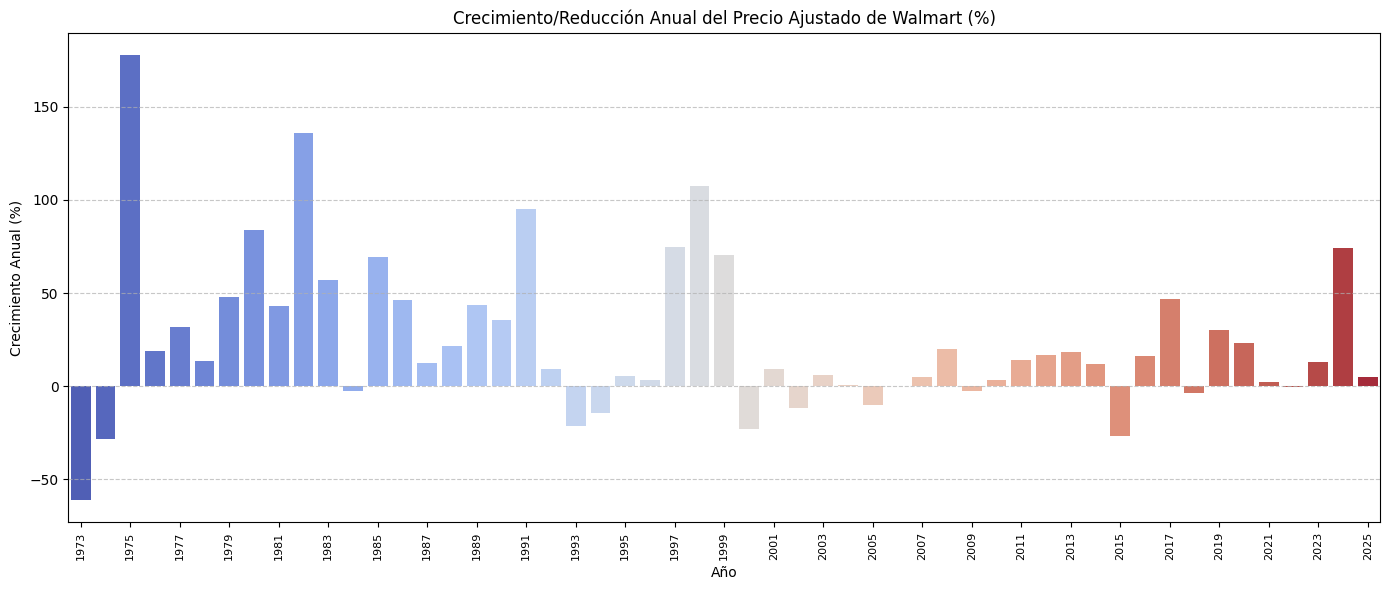

In [ ]:
print("\n4.7 Cálculo y Visualización del Crecimiento/Reducción Anual...")
# Necesitamos extraer el año del índice DatetimeIndex
if isinstance(serie.index, pd.DatetimeIndex):
    # Obtener el último precio ajustado de cada año
    #annual_prices = serie.groupby(serie.index.year)['adj_close'].last() # This line caused the error
    annual_prices = serie.groupby(serie.index.year).last()  # Corrected line: use .last() directly on the Series
    # Calcular tasas de crecimiento/reducción anuales (%)
    annual_growth = annual_prices.pct_change() * 100

    # Convertir en DataFrame para visualización
    annual_growth_df = annual_growth.dropna().reset_index()
    annual_growth_df.columns = ['Año', 'Crecimiento (%)']

    print("Primeras filas del crecimiento anual:")
    print(annual_growth_df.head())

    # Gráfico de razones de crecimiento/reducción
    plt.figure(figsize=(14, 6))
    sns.barplot(data=annual_growth_df, x='Año', y='Crecimiento (%)', palette='coolwarm')
    plt.xticks(rotation=90, fontsize=8) # Ajustar fontsize si hay muchos años
    plt.title('Crecimiento/Reducción Anual del Precio Ajustado de Walmart (%)')
    plt.xlabel('Año')
    plt.ylabel('Crecimiento Anual (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Ajustar ticks del eje x si hay muchos años para evitar solapamiento
    ax = plt.gca()
    n_years = len(annual_growth_df['Año'])
    tick_spacing = max(1, n_years // 20) # Mostrar una etiqueta cada 'tick_spacing' años aprox.
    ax.set_xticks(ax.get_xticks()[::tick_spacing])
    plt.tight_layout()
    plt.show()
else:
    print("El índice no es DatetimeIndex, no se puede agrupar por año fácilmente.")

## **5. METODOLOGÍA BOX-JENKINS PARA MODELO ARIMA**

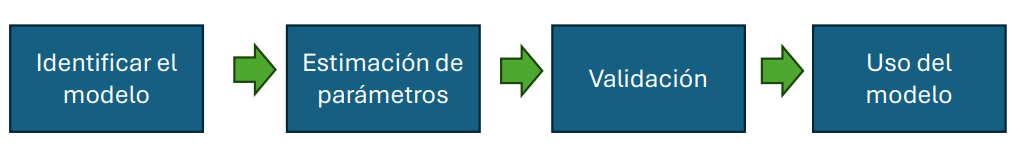

### **5.1 Identificación**


5.1.1 Verificando estacionariedad de la serie original (Prueba ADF)...
ADF Statistic: 7.2116
p-value: 1.0000
Critical Values:
	1%: -3.4308
	5%: -2.8618
	10%: -2.5669

Resultado ADF (p-value=1.0000): La serie original NO es estacionaria. Aplicando diferencias...

ADF Test (d=1) p-value: 0.0000
La serie con d=1 ES estacionaria.

Orden de diferenciación seleccionado: d = 1


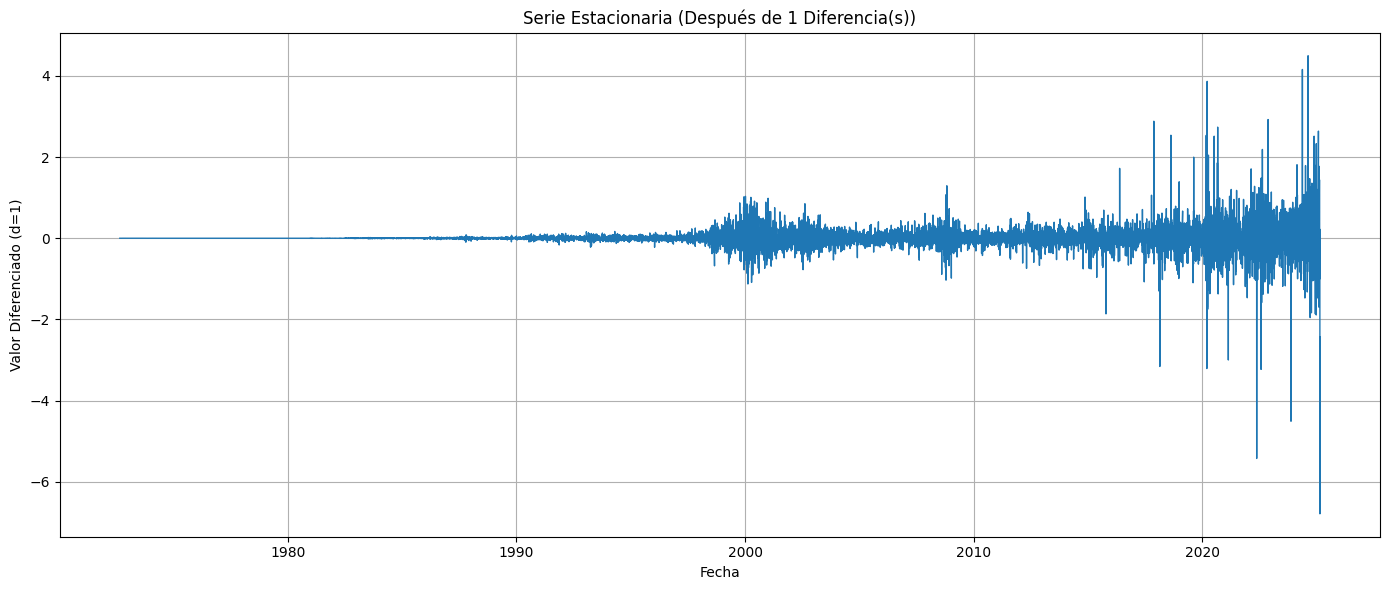

In [ ]:
# 5.1.1 Verificar Estacionariedad (Prueba Dickey-Fuller Aumentada - ADF)
print("\n5.1.1 Verificando estacionariedad de la serie original (Prueba ADF)...")
# H0: La serie NO es estacionaria (tiene raíz unitaria).
# H1: La serie ES estacionaria (no tiene raíz unitaria).
result_adf = adfuller(serie)
print(f'ADF Statistic: {result_adf[0]:.4f}')
print(f'p-value: {result_adf[1]:.4f}')
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value:.4f}')

# Determinar orden de diferenciación 'd'
d = 0
serie_estacionaria = serie # Inicialmente asumimos que es la original
if result_adf[1] > 0.05:
    print(f"\nResultado ADF (p-value={result_adf[1]:.4f}): La serie original NO es estacionaria. Aplicando diferencias...")
    # Probar con d=1
    serie_diff1 = serie.diff().dropna()
    result_adf_diff1 = adfuller(serie_diff1)
    print(f'\nADF Test (d=1) p-value: {result_adf_diff1[1]:.4f}')
    if result_adf_diff1[1] <= 0.05:
        print("La serie con d=1 ES estacionaria.")
        d = 1
        serie_estacionaria = serie_diff1
    else:
        # Probar con d=2
        print("La serie con d=1 NO es estacionaria. Probando d=2...")
        serie_diff2 = serie_diff1.diff().dropna()
        result_adf_diff2 = adfuller(serie_diff2)
        print(f'ADF Test (d=2) p-value: {result_adf_diff2[1]:.4f}')
        if result_adf_diff2[1] <= 0.05:
            print("La serie con d=2 ES estacionaria.")
            d = 2
            serie_estacionaria = serie_diff2
        else:
            print("Advertencia: La serie sigue sin ser estacionaria con d=2. Reconsiderar transformaciones (ej. log) o el modelo. Usando d=2 por ahora.")
            d = 2
            serie_estacionaria = serie_diff2 # Continuar con precaución
else:
    print(f"\nResultado ADF (p-value={result_adf[1]:.4f}): La serie original ES estacionaria (d=0).")

print(f"\nOrden de diferenciación seleccionado: d = {d}")

# Visualizar serie estacionaria (si se diferenció)
if d > 0:
    plt.figure(figsize=(14, 6))
    plt.plot(serie_estacionaria.index, serie_estacionaria, linewidth=1.0)
    plt.title(f'Serie Estacionaria (Después de {d} Diferencia(s))')
    plt.xlabel('Fecha')
    plt.ylabel(f'Valor Diferenciado (d={d})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


5.1.2 Analizando ACF y PACF de la serie estacionaria (d=1) para sugerir p y q...


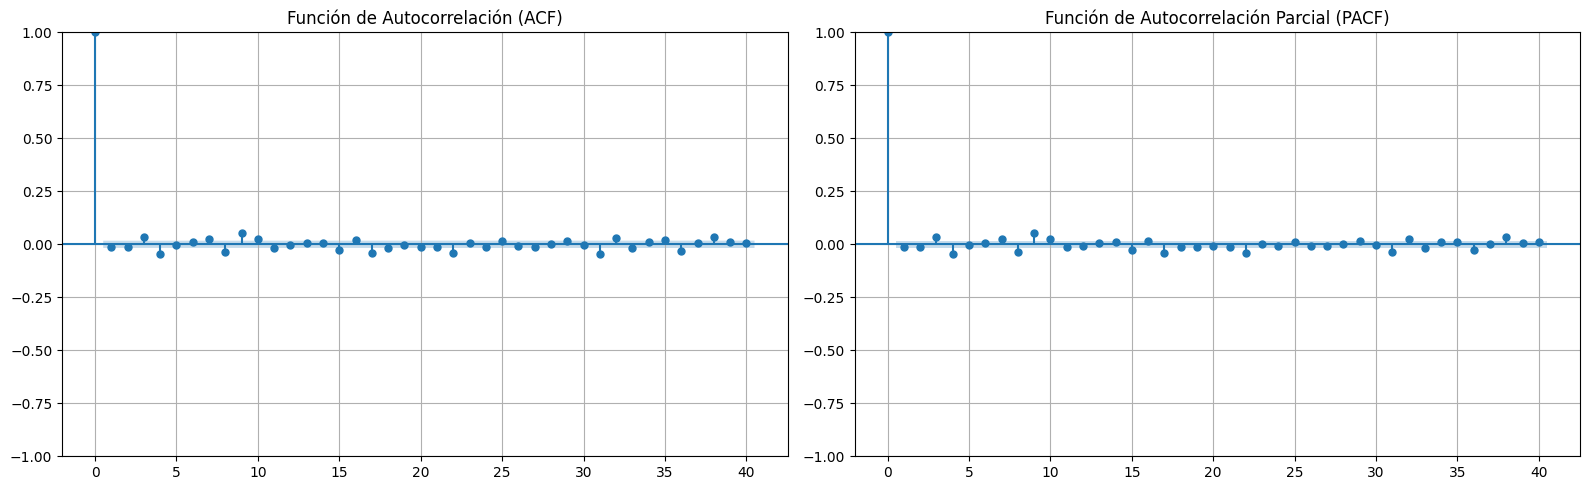

In [ ]:
# 5.1.2 Identificar 'p' y 'q' (Análisis ACF y PACF de la serie estacionaria)
print(f"\n5.1.2 Analizando ACF y PACF de la serie estacionaria (d={d}) para sugerir p y q...")
lags_acf_pacf = 40 # Número de lags a mostrar

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(serie_estacionaria, ax=axes[0], lags=lags_acf_pacf, title='Función de Autocorrelación (ACF)')
axes[0].grid(True)
plot_pacf(serie_estacionaria, ax=axes[1], lags=lags_acf_pacf, title='Función de Autocorrelación Parcial (PACF)', method='ywm') # 'ywm' es Yule-Walker, común para PACF
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Guía para Interpretar ACF/PACF ---")
print("  - Buscar el lag donde la ACF 'corta' (cae a cero) -> sugiere orden 'q' para MA(q).")
print("  - Buscar el lag donde la PACF 'corta' (cae a cero) -> sugiere orden 'p' para AR(p).")
print("  - Si ambas decaen lentamente -> sugiere modelo mixto ARMA(p, q).")
print("  - Las bandas azules indican el intervalo de confianza; lags fuera de ellas son significativos.")
p_elegido = 2 # <-- CAMBIAR SEGÚN INTERPRETACIÓN DE PACF
q_elegido = 2 # <-- CAMBIAR SEGÚN INTERPRETACIÓN DE ACF
print(f"\nÓrdenes iniciales seleccionados para el modelo: ARIMA(p={p_elegido}, d={d}, q={q_elegido})")

### Nota: Checar "p" y "q" y ajustarlos segun la interpretación


--- Guía para Interpretar ACF/PACF ---
  - Buscar el lag donde la ACF 'corta' (cae a cero) -> sugiere orden 'q' para MA(q).
  - Buscar el lag donde la PACF 'corta' (cae a cero) -> sugiere orden 'p' para AR(p).
  - Si ambas decaen lentamente -> sugiere modelo mixto ARMA(p, q).
  - Las bandas azules indican el intervalo de confianza; lags fuera de ellas son significativos.

Órdenes iniciales seleccionados para el modelo: ARIMA(p=2, d=1, q=2)


### **5.2 Estimación del Modelo**

#### 5.2.1 Ajuste manual

In [ ]:
# Dividir datos para entrenamiento y prueba (ej. 80% entrenamiento, 20% prueba)
# Es importante hacerlo ANTES de ajustar el modelo
train_ratio = 0.80
split_index = int(len(serie) * train_ratio)
train_data = serie[:split_index]
test_data = serie[split_index:]

print(f"Tamaño Total Serie: {len(serie)} puntos")
print(f"Tamaño Entrenamiento: {len(train_data)} puntos ({train_data.index.min().strftime('%Y-%m-%d')} a {train_data.index.max().strftime('%Y-%m-%d')})")
print(f"Tamaño Prueba:       {len(test_data)} puntos ({test_data.index.min().strftime('%Y-%m-%d')} a {test_data.index.max().strftime('%Y-%m-%d')})")

print(f"\nAjustando modelo ARIMA(p={p_elegido}, d={d}, q={q_elegido}) en los datos de entrenamiento...")
try:
    # Ajustar el modelo ARIMA usando la serie de ENTRENAMIENTO
    # El modelo maneja la diferenciación 'd' internamente si se especifica
    modelo = ARIMA(train_data, order=(p_elegido, d, q_elegido))
    modelo_ajustado = modelo.fit()

    # Mostrar resumen del modelo (contiene coeficientes, errores estándar, AIC, BIC, etc.)
    print("\nResumen del Modelo Ajustado:")
    print(modelo_ajustado.summary())
    model_fitted = True # Bandera para saber si el modelo se ajustó

except Exception as e:
    print(f"\nERROR al ajustar el modelo ARIMA({p_elegido},{d},{q_elegido}): {e}")
    print("Verifica los órdenes (p,d,q), la estacionariedad de la serie o posibles problemas en los datos.")
    model_fitted = False # El modelo no se ajustó


Tamaño Total Serie: 13233 puntos
Tamaño Entrenamiento: 10586 puntos (1972-08-25 a 2014-08-13)
Tamaño Prueba:       2647 puntos (2014-08-14 a 2025-02-21)

Ajustando modelo ARIMA(p=2, d=1, q=2) en los datos de entrenamiento...

Resumen del Modelo Ajustado:
                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                10586
Model:                 ARIMA(2, 1, 2)   Log Likelihood                7156.671
Date:                Sun, 13 Apr 2025   AIC                         -14303.343
Time:                        20:26:51   BIC                         -14267.007
Sample:                             0   HQIC                        -14291.078
                              - 10586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

### **5.3 Diagnóstico del Modelo o Validación del Modelo**

Nota: Solo proceder si el modelo se ajustó correctamente

#### 5.3.1 Gráfico de Residuos vs Tiempo


5.3.1 Gráfico de Residuos vs Tiempo...


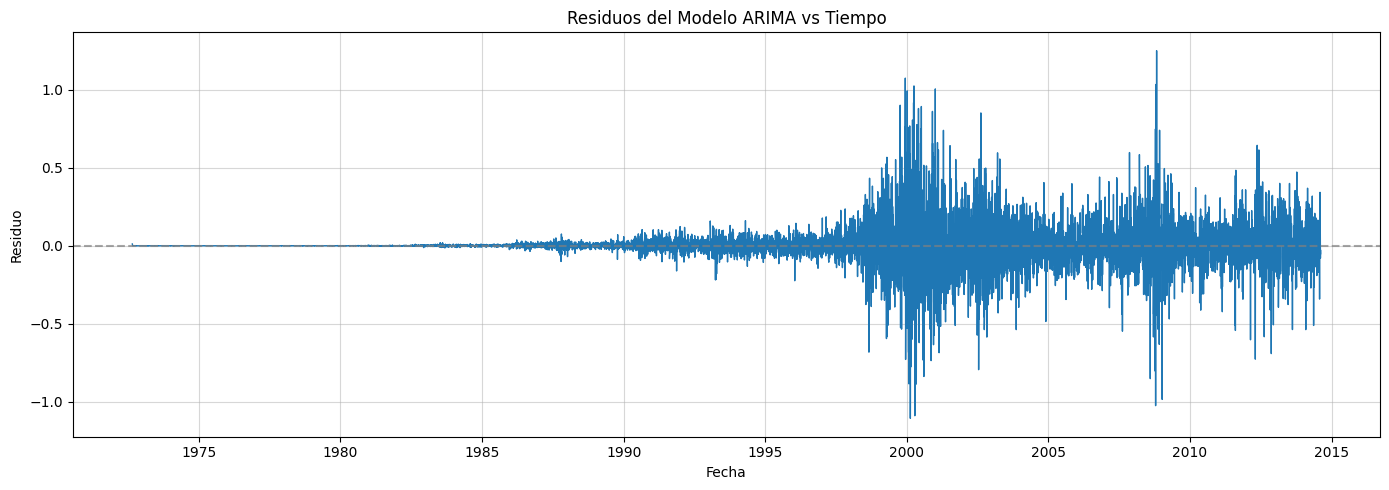

In [ ]:
# 5.3.1 Gráfico de Residuos vs Tiempo
print("\n5.3.1 Gráfico de Residuos vs Tiempo...")
# Calculate residuals from the fitted model
if model_fitted: # Check if model was successfully fitted
  residuos = modelo_ajustado.resid

  fig, ax = plt.subplots(1, 1, figsize=(14, 5))
  ax.plot(residuos.index, residuos, linewidth=1)
  ax.set_title('Residuos del Modelo ARIMA vs Tiempo')
  ax.set_xlabel('Fecha')
  ax.set_ylabel('Residuo')
  ax.axhline(0, linestyle='--', color='gray', alpha=0.7) # Línea en cero
  ax.grid(True, alpha=0.5)
  plt.tight_layout()
  plt.show()
  # Buscar: ¿Patrones obvios? ¿Varianza constante? ¿Media cero?
else:
  print("El modelo no se ajustó correctamente, por lo que no se pueden calcular los residuos.")

#### 5.3.2 ACF y QQ-plot de los Residuos


5.3.2 ACF y QQ-Plot de Residuos...


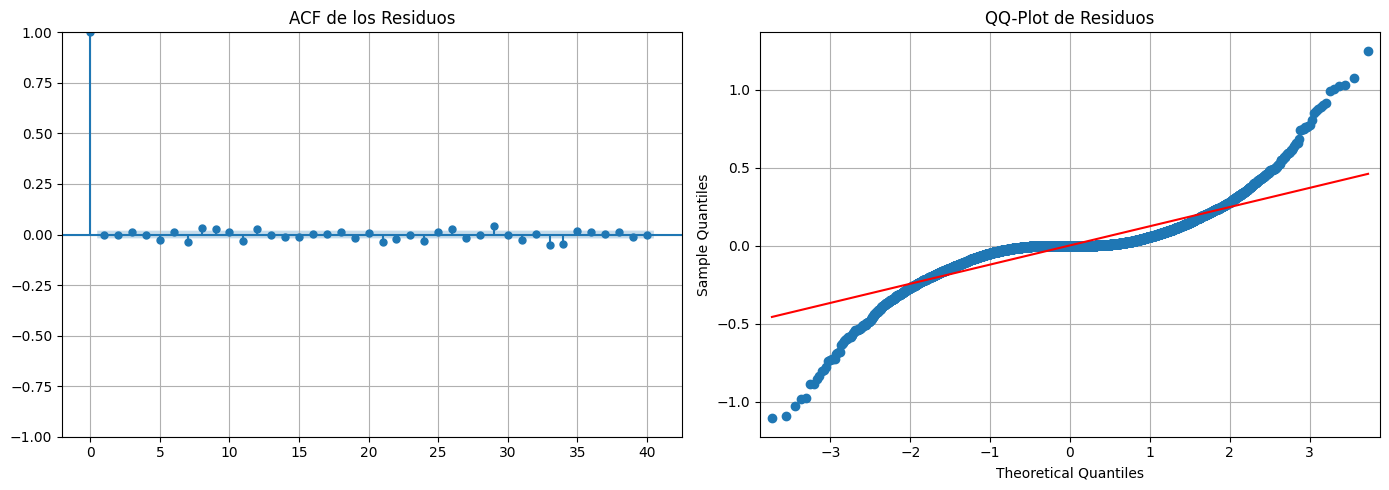

In [ ]:
print("\n5.3.2 ACF y QQ-Plot de Residuos...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# ACF de residuos (Esperamos que estén dentro de las bandas -> no autocorrelación)
plot_acf(residuos, lags=lags_acf_pacf, ax=axes[0], title='ACF de los Residuos')
axes[0].grid(True)
# QQ-plot (Esperamos que los puntos sigan la línea -> normalidad)
sm.qqplot(residuos, line='s', ax=axes[1]) # 's' para línea estandarizada
axes[1].set_title('QQ-Plot de Residuos')
axes[1].grid(True)
plt.tight_layout()
plt.show()

#### 5.3.3 Prueba de Ljung-Box (Prueba formal de autocorrelación)

In [ ]:
print("\n5.3.3 Prueba de Ljung-Box para autocorrelación de residuos...")
# H0: Los residuos son independientes (no hay autocorrelación). -> Queremos p-value > 0.05
ljung_box_lags = min(lags_acf_pacf, len(train_data)//5) # Usar un número razonable de lags
ljung_box_result = sm.stats.acorr_ljungbox(residuos, lags=ljung_box_lags, return_df=True)
print(ljung_box_result)

# Interpretar Ljung-Box
if (ljung_box_result['lb_pvalue'] < 0.05).any():
    print("\nResultado Ljung-Box: ¡Advertencia! Se rechaza H0 para al menos un lag (p<0.05).")
    print("Hay evidencia de autocorrelación significativa en los residuos.")
    print("El modelo NO captura toda la estructura de autocorrelación. Considera:")
    print("  - Revisar los órdenes (p, q).")
    print("  - Incluir términos estacionales (SARIMA) si la descomposición lo sugiere.")
    print("  - Buscar variables exógenas omitidas (ARIMAX).")
    diagnosis_ok = False
else:
    print("\nResultado Ljung-Box: No se rechaza H0 (todos los p>=0.05).")
    print("Los residuos parecen ser ruido blanco (independientes), lo cual es bueno.")
    diagnosis_ok = True

print("\n--- Fin del Diagnóstico ---")
if diagnosis_ok:
      print("El diagnóstico sugiere que el modelo es razonablemente adecuado.")
else:
      print("El diagnóstico sugiere problemas con el modelo. Las predicciones deben tomarse con precaución.")


5.3.3 Prueba de Ljung-Box para autocorrelación de residuos...
       lb_stat     lb_pvalue
1     0.012677  9.103534e-01
2     0.012792  9.936245e-01
3     1.143827  7.665059e-01
4     1.177824  8.817360e-01
5     8.650158  1.238585e-01
6     9.768999  1.347231e-01
7    22.618119  1.986110e-03
8    32.933718  6.330502e-05
9    40.563314  6.005350e-06
10   42.802408  5.394261e-06
11   53.104874  1.718126e-07
12   61.999908  9.726543e-09
13   62.157765  2.153775e-08
14   63.779626  2.523369e-08
15   65.450260  2.848833e-08
16   65.593255  5.822180e-08
17   65.863094  1.097931e-07
18   67.891887  1.023944e-07
19   70.409349  7.863141e-08
20   71.025372  1.237671e-07
21   86.190777  7.268145e-10
22   90.469028  2.851542e-10
23   90.469416  5.928417e-10
24  100.682183  2.297817e-11
25  102.657421  2.230254e-11
26  109.965248  2.679113e-12
27  113.558956  1.382353e-12
28  113.667143  2.773987e-12
29  131.057384  6.276725e-15
30  131.148378  1.310595e-14
31  138.896979  1.311881e-15
32  138.8

### **5.4 Predicción (Uso del Modelo)**

Nota: Solo proceder si el modelo se ajustó (y opcionalmente, si el diagnóstico fue aceptable)

In [ ]:
# Número de pasos a predecir (longitud del conjunto de prueba)
n_predicciones = len(test_data)
print(f"Realizando {n_predicciones} predicciones sobre el conjunto de prueba...")

# Obtener predicciones y intervalos de confianza del 95%
forecast_results = modelo_ajustado.get_forecast(steps=n_predicciones)
pred_mean = forecast_results.predicted_mean
pred_ci = forecast_results.conf_int(alpha=0.05) # alpha=0.05 para 95% CI

# Asegurar que el índice de la predicción coincida con el del conjunto de prueba
pred_mean.index = test_data.index
pred_ci.index = test_data.index

Realizando 2647 predicciones sobre el conjunto de prueba...


#### 5.4.1 Visualizar Predicciones vs Datos Reales ó Uso delo Modelo


5.4.1 Visualización de Predicciones vs Datos Reales...


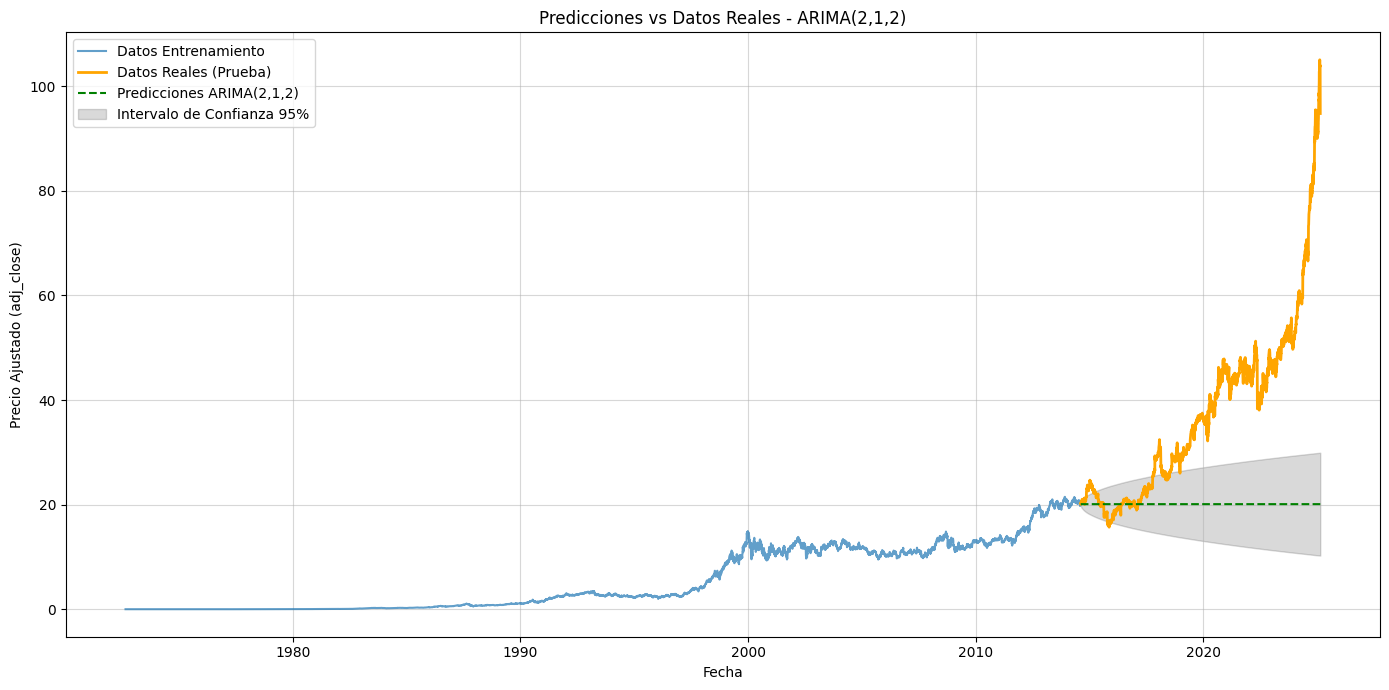

In [ ]:
print("\n5.4.1 Visualización de Predicciones vs Datos Reales...")
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Datos Entrenamiento', alpha=0.7)
plt.plot(test_data.index, test_data, label='Datos Reales (Prueba)', color='orange', linewidth=2)
plt.plot(pred_mean.index, pred_mean, label=f'Predicciones ARIMA({p_elegido},{d},{q_elegido})', color='green', linestyle='--')
# Sombrear el intervalo de confianza
plt.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0], # Columna inferior del CI
                  pred_ci.iloc[:, 1], # Columna superior del CI
                  color='k', alpha=0.15, label='Intervalo de Confianza 95%')

plt.title(f'Predicciones vs Datos Reales - ARIMA({p_elegido},{d},{q_elegido})')
plt.xlabel('Fecha')
plt.ylabel('Precio Ajustado (adj_close)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
# Opcional: Zoom en el área de predicción si la serie es muy larga
# plt.xlim([test_data.index.min() - pd.Timedelta(days=30), test_data.index.max() + pd.Timedelta(days=5)])
plt.tight_layout()
plt.show()

#### 5.4.2 Evaluar el Rendimiento Numéricamente

In [ ]:
print("\n5.4.2 Evaluación Numérica del Modelo (en conjunto de prueba)...")
try:
    rmse = np.sqrt(mean_squared_error(test_data, pred_mean))
    print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
    # Calcular MAE (Mean Absolute Error)
    mae = np.mean(np.abs(test_data - pred_mean))
    print(f'  Mean Absolute Error (MAE):      {mae:.4f}')
    # Calcular MAPE (Mean Absolute Percentage Error) - Cuidado con ceros en test_data
    if (test_data == 0).any():
          print("  Advertencia: No se calcula MAPE porque hay ceros en los datos reales.")
          mape = np.nan
    else:
          mape = np.mean(np.abs((test_data - pred_mean) / test_data)) * 100
          print(f'  Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

except Exception as e:
      print(f"Error al calcular métricas de evaluación: {e}")


5.4.2 Evaluación Numérica del Modelo (en conjunto de prueba)...
  Root Mean Squared Error (RMSE): 24.3788
  Mean Absolute Error (MAE):      17.7698
  Mean Absolute Percentage Error (MAPE): 37.70%


## **6. CONCLUSIONES FINALES**

In [ ]:
print(f"Se analizó la serie de tiempo del precio ajustado de cierre de Walmart (WMT) de {serie.index.min().strftime('%Y-%m-%d')} a {serie.index.max().strftime('%Y-%m-%d')}.")
print("Se aplicó la metodología Box-Jenkins para intentar ajustar un modelo ARIMA.")

# Resumen de Identificación
if 'result_adf' in locals():
    is_stationary_initial = result_adf[1] <= 0.05
    print(f"\nIdentificación:")
    print(f"  - La serie original {'ERA' if is_stationary_initial else 'NO era'} estacionaria (ADF p-value: {result_adf[1]:.4f}).")
    if not is_stationary_initial:
        print(f"  - Se determinó un orden de diferenciación d={d} para lograr estacionariedad.")
    else:
        print(f"  - No se requirió diferenciación (d={d}).")
    print(f"  - El análisis ACF/PACF de la serie estacionaria se utilizó para proponer p={p_elegido} y q={q_elegido}.")
else:
    print("\nIdentificación: No se completó la fase de identificación.")

# Resumen de Estimación y Diagnóstico
if model_fitted:
    print(f"\nEstimación y Diagnóstico:")
    print(f"  - Se ajustó exitosamente un modelo ARIMA({p_elegido}, {d}, {q_elegido}) a los datos de entrenamiento.")
    if diagnosis_ok:
        print("  - El diagnóstico de los residuos (Ljung-Box, gráficos ACF/QQ) sugiere que el modelo es estadísticamente adecuado (residuos como ruido blanco).")
    else:
        print("  - ¡Advertencia! El diagnóstico de los residuos indicó problemas (autocorrelación residual). El modelo podría no ser adecuado.")
else:
    print("\nEstimación y Diagnóstico: No se pudo ajustar un modelo con los parámetros seleccionados.")

# Resumen de Predicción
if model_fitted: # Asumiendo que se intentó la predicción si el modelo ajustó
    print("\nPredicción:")
    if 'rmse' in locals():
         print(f"  - En el conjunto de prueba, el modelo obtuvo un RMSE de {rmse:.4f} y un MAE de {mae:.4f}.")
         if not np.isnan(mape):
             print(f"  - El MAPE fue de {mape:.2f}%.")
    else:
         print("  - No se pudieron calcular las métricas de rendimiento en el conjunto de prueba.")
    print("  - La visualización muestra [Describe brevemente cómo se ven las predicciones vs los reales: ej., siguen la tendencia, subestiman/sobreestiman, etc.].") # <-- COMPLETAR INTERPRETACIÓN VISUAL
else:
    print("\nPredicción: No se realizó predicción.")

Se analizó la serie de tiempo del precio ajustado de cierre de Walmart (WMT) de 1972-08-25 a 2025-02-21.
Se aplicó la metodología Box-Jenkins para intentar ajustar un modelo ARIMA.

Identificación:
  - La serie original NO era estacionaria (ADF p-value: 1.0000).
  - Se determinó un orden de diferenciación d=1 para lograr estacionariedad.
  - El análisis ACF/PACF de la serie estacionaria se utilizó para proponer p=2 y q=2.

Estimación y Diagnóstico:
  - Se ajustó exitosamente un modelo ARIMA(2, 1, 2) a los datos de entrenamiento.
  - ¡Advertencia! El diagnóstico de los residuos indicó problemas (autocorrelación residual). El modelo podría no ser adecuado.

Predicción:
  - En el conjunto de prueba, el modelo obtuvo un RMSE de 24.3788 y un MAE de 17.7698.
  - El MAPE fue de 37.70%.
  - La visualización muestra [Describe brevemente cómo se ven las predicciones vs los reales: ej., siguen la tendencia, subestiman/sobreestiman, etc.].
